In [ ]:
try:
    import torch
    from torch import nn
    from torch.utils.data import DataLoader

    import torchvision
    from torchvision import transforms
    from torchvision import datasets

    import matplotlib.pyplot as plt
except:
    !pip install torch
    !pip install torchvision
    !pip install matplotlib
    
    import torch
    from torch import nn
    from torch.utils.data import DataLoader

    import torchvision
    from torchvision import transforms
    from torchvision import datasets

    import matplotlib.pyplot as plt

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(torch.__version__)

In [ ]:
from pathlib import Path
TRAINING_SET_PATH = Path('datasets/training_set')
TEST_SET_PATH = Path('datasets/test_set')

TRAINING_SET_PATH, TEST_SET_PATH

In [ ]:
#importing the datasets from torchvision.datasets
train_data = datasets.MNIST(
    root=TRAINING_SET_PATH,
    download=True,
    train=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root=TEST_SET_PATH,
    train=False, #testset
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets/training_set
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
len(train_data[0])

2

In [12]:
train_data[0][1]

5

In [13]:
image, label = train_data[0]

In [34]:
label

5

In [14]:
#to get the dimension of an image
image.shape

torch.Size([1, 28, 28])

Image is black and white

In [15]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [18]:
len(train_data.targets)

60000

In [19]:
len(test_data.targets)

10000

In [35]:
class_names = train_data.classes
class_names[1]
class_names[label]

'5 - five'

In [36]:
image.shape

torch.Size([1, 28, 28])

In [37]:
image.squeeze().shape

torch.Size([28, 28])

#### were working with `60000` train data samples and `10000` test data samples

>## visualizing

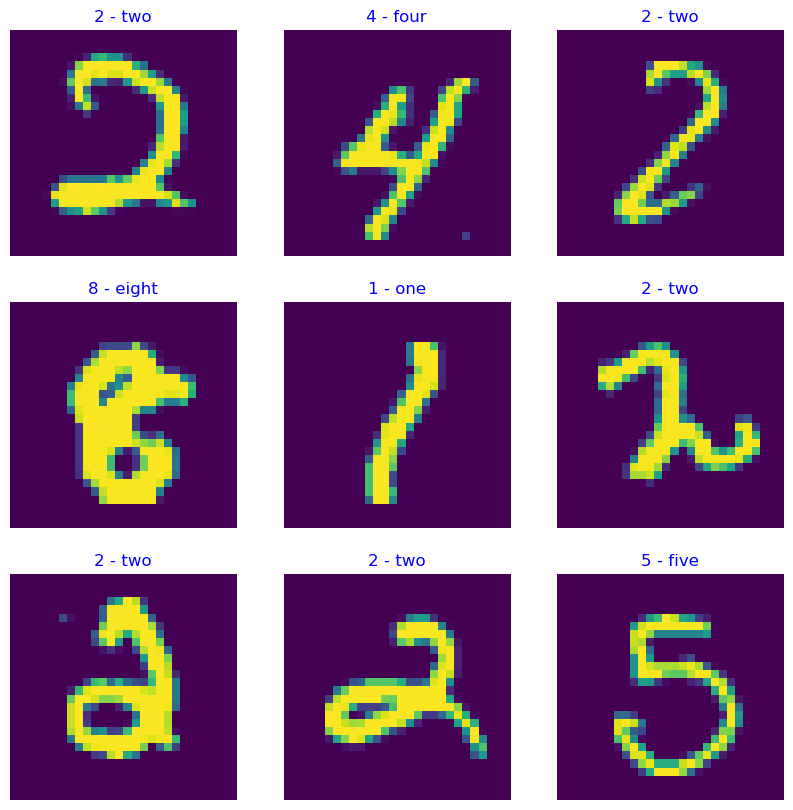

In [47]:
#visualizing
sample_grid = plt.figure(figsize=(10,10))
rows, cols = 3, 3
for i in range (1,rows*cols+1):
    random_no = torch.randint(0,len(train_data), size=[1]).item()
    image, label = train_data[random_no]
    sample_grid.add_subplot(rows, cols, i)
    plt.axis(False)
    plt.title(class_names[label], c='b')
    plt.imshow(image.squeeze()) #we need to squeeze as matplotlib only takes in 2d
    

In [58]:
rand = torch.rand(size=(1,))
rand.item()

0.6986685395240784

In [29]:
rand1 = torch.randint(0, len(train_data),size=[1])
rand1.item()

31935

>## loading data

In [62]:
BATCH_SIZE = 32 #const

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE 
)

len(train_dataloader), len(test_dataloader)


(1875, 313)

In [63]:
32*1875

60000

In [64]:
len(train_data)

60000

In [70]:
X_train_batch, y_train_batch = next(iter(train_dataloader))
X_train_batch.shape, y_train_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [72]:
X_train_batch[0].shape

torch.Size([1, 28, 28])

In [74]:
len(X_train_batch)

32

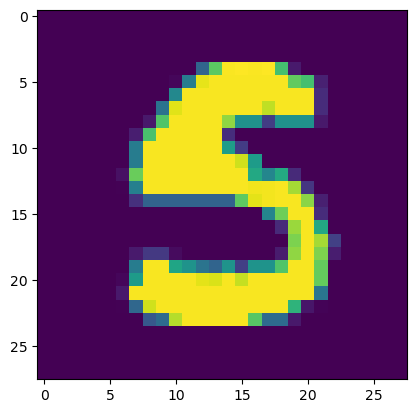

In [77]:
#random train image visual
random_no2 = torch.randint(0, len(X_train_batch), size=[1]).item()
plt.imshow(X_train_batch[random_no2].squeeze())

In [85]:
class MNISTModelV1(nn.Module):
    """
    TinyVGG model Arch.
    mddel from CNN explainers website https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            #create a conv layer
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #values wew can set ourselfs are called hyperparameters called nn conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),    
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)          
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
                     
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,#there is a trick to calculate this!
                      out_features=output_shape),
            
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # print("output shape fp conv layer 2",x.shape) #use this to get dim of in features in classification layer
        x = self.classifier(x)
        return x


In [86]:
#pass rand_tensor of similar dims into model to get dim after nn.flatten()
rand_image_tensor = torch.randn(size=(1,28,28))
model_1 = MNISTModelV1(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_1(rand_image_tensor.unsqueeze(dim=0).to(device=device))

tensor([[ 0.0177, -0.0480,  0.0064,  0.1251, -0.0063, -0.0229,  0.1199,  0.0207,
         -0.0378, -0.0055]], device='cuda:0', grad_fn=<AddmmBackward0>)